In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import functools

import numpy as np
import scipy as sp
import ultraplot as uplt
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from folx import forward_laplacian

In [3]:
MU = 4

def _neg_log_like_gauss1d(x, sigma, mu=0.0):
    return 0.5 * jnp.sum((x-mu)**2) / sigma**2 + jnp.log(sigma) + 0.5 * jnp.log(2.0 * jnp.pi)

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2

    return jnp.sum(-5.0*x*x + x**4)
    # return _neg_log_like_gauss1d(x, 1)
    return -1.0 * jsp.special.logsumexp(
        jnp.array([
            -_neg_log_like_gauss1d(x, 0.25, mu=-MU) + jnp.log(0.25),
            -_neg_log_like_gauss1d(x, 1, mu=MU) + jnp.log(0.75),
        ])
    )
    # # s2pi = jnp.sqrt(2.0 * jnp.pi)
    # # sigma = 0.25
    # # val = 0.25 * jnp.exp(-0.5 * jnp.power((x + MU) / sigma, 2.0)) / sigma / s2pi
    # # sigma = 1.0
    # # val = val + 0.75 * jnp.exp(-0.5 * jnp.power((x - MU) / sigma, 2.0)) / sigma / s2pi
    # # return -1.0 * jnp.log(jnp.sum(val))


@functools.partial(jax.jit, static_argnames="fun")
def _value_and_grad_forward_laplacian(x, fun):
    def _fun_for_grad_flp(x):
        res = forward_laplacian(fun)(x)
        return res.laplacian, res
    grad_lp, res = jax.jacfwd(_fun_for_grad_flp, has_aux=True)(x)
    return res.x, res.jacobian.dense_array[0], res.laplacian, grad_lp

In [4]:
@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _kick_c(q, p, b, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    p = p - dt * gv
    return q, p, b, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _drift_c(q, p, b, pr, vfun, dt, d, hbar, m):
    q = q + dt / m * p
    return q, p, b, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _evolve_state_c(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift_c(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _kick_c(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _kick_symp(q, p, r, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    p = p - dt * (gv + r / 2 / jnp.sqrt(d) * glpv)
    pr = pr - dt * (lpv / 2 / jnp.sqrt(d) - jnp.power(d, 1.5) * hbar * hbar / 8 / m / r / r)
    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _drift_symp(q, p, r, pr, vfun, dt, d, hbar, m):
    q = q + dt / m * p
    pr_fac = 1.0 + dt * 2.0 / m / jnp.sqrt(d) * pr
    r = r * pr_fac * pr_fac
    pr = pr / pr_fac

    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _evolve_state_symp(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick_symp(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift_symp(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _kick_symp(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr


def rpr2ab(r, pr, d, hbar):
    a = 2.0 / jnp.sqrt(d) * pr
    b = hbar * jnp.sqrt(d) / 2 / r
    return a, b


def ab2rpr(a, b, d, hbar):
    pr = jnp.sqrt(d) / 2.0 * a
    r = hbar * jnp.sqrt(d) / 2 / b
    return r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _kick_pois(q, p, r, pr, vfun, dt, d, hbar, m):
    v, gv, lpv, glpv = _value_and_grad_forward_laplacian(q, vfun)
    p = p - dt * (gv + r / 2 / jnp.sqrt(d) * glpv)
    pr = pr - dt * (lpv / 2 / jnp.sqrt(d))
    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _drift_pois(q, p, r, pr, vfun, dt, d, hbar, m):
    q = q + dt / m * p
    a, b = rpr2ab(r, pr, d, hbar)
    c = a + 1j * b
    c = c / (1.0 + dt * c / m)
    a = jnp.real(c)
    b = jnp.imag(c)
    r, pr = ab2rpr(a, b, d, hbar)
    return q, p, r, pr


@functools.partial(jax.jit, static_argnames=("vfun", "dt", "d", "hbar", "m"))
def _evolve_state_pois(q, p, r, pr, vfun, dt, d, hbar, m):
    q, p, r, pr = _kick_pois(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    q, p, r, pr = _drift_pois(q, p, r, pr, vfun, dt, d, hbar, m)
    q, p, r, pr = _kick_pois(q, p, r, pr, vfun, dt/2.0, d, hbar, m)
    return q, p, r, pr


In [5]:
hbar = 0.01
d = 1
m = 1
vfun = _neg_log_like
dt = 0.1

q = -7.0
p = -1.0
r = 1e-3
pr = -6.0

val = jax.jacobian(_evolve_state_pois, argnums=[0, 1, 2, 3])(q, p, r, pr, vfun, dt, d, hbar, m)
# val = _evolve_state_symp(q, p, r, pr, vfun, dt, d, hbar, m)
print(jnp.linalg.det(jnp.array(val)))
# jnp.linalg.det(jnp.array())


0.9999999999999964


In [147]:
import tqdm

hbar = 0.01
d = 1
m = 1
vfun = _neg_log_like

dt = 0.000001
n_steps = 950000

q = 0.0
p = -10.0
r = 1e7
pr = 1.7

states = np.zeros((4, n_steps))
states[0, 0] = q
states[1, 0] = p
states[2, 0] = r
states[3, 0] = pr
states_c = np.zeros((2, n_steps))
states_c[0, 0] = q
states_c[1, 0] = p

ec = []
ec.append(jnp.ravel(p * p / 2 / m + _neg_log_like(q)))
eq = []
_, _, flpx, _ = _value_and_grad_forward_laplacian(jnp.array([q]), vfun)
# r = hbar * jnp.sqrt(d) / 2 / b
eq.append(jnp.ravel(
    1 / (2.0 * jnp.sqrt(d)) * (r*flpx + r*4.0 / m * pr * pr + hbar*hbar*d/4/m/r)
))

for i in tqdm.trange(1, n_steps, ncols=80):
    q, p, r, pr = states[0, i-1:i], states[1, i-1:i], states[2, i-1:i], states[3, i-1:i]
    q, p, r, pr = _evolve_state_pois(q, p, r, pr, vfun, dt, d, hbar, m)
    states[0, i:i+1] = q
    states[1, i:i+1] = p
    states[2, i:i+1] = r
    states[3, i:i+1] = pr
    ec.append(jnp.ravel(p * p / 2 / m + _neg_log_like(q)))
    _, _, flpx, _ = _value_and_grad_forward_laplacian(q, vfun)
    # r = hbar * jnp.sqrt(d) / 2 / b
    eq.append(jnp.ravel(
        1 / (2.0 * jnp.sqrt(d)) * (r*flpx + r*4.0 / m * pr * pr + hbar*hbar*d/4/m/r)
    ))

    q, p = states_c[0, i-1:i], states_c[1, i-1:i]
    q, p, _, _ = _evolve_state_c(q, p, r, pr, vfun, dt, d, hbar, m)
    states_c[0, i:i+1] = q
    states_c[1, i:i+1] = p

ec = jnp.array(ec)
eq = jnp.array(eq)


100%|█████████████████████████████████| 949999/949999 [03:06<00:00, 5092.03it/s]


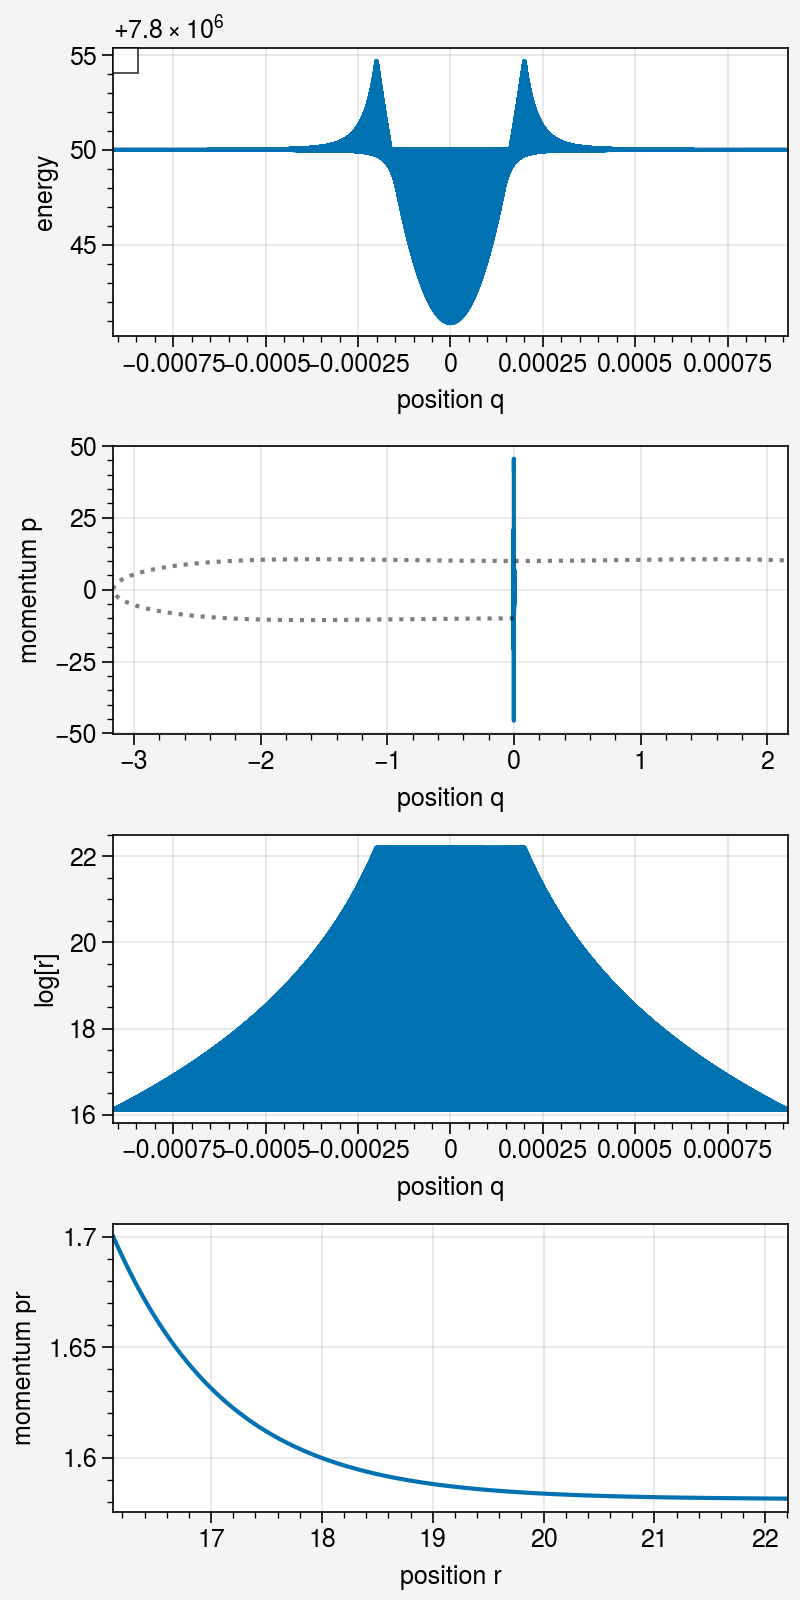

In [148]:
ns = 0
n = states.shape[1]

# fig, axs = uplt.subplots(nrows=2, ncols=1, sharey=0, figsize=(4, 6))

# xp = jnp.linspace(-10, 10, 1000)
# axs[0, 0].plot(xp, vmnll(xp) + r / 2.0 / jnp.sqrt(d) * vmlapnll(xp), label="quantum")
# axs[0, 0].plot(xp, vmnll(xp), color="k", label="classical")
# axs[0, 0].format(xlim=(-10, 10), ylabel="potential V(q)")

# axs[1, 0].plot(states[0, ns:n], states[1, ns:n], label="quantum")
# axs[1, 0].plot(states_c[0, ns:n], states_c[1, ns:n], color="k", label="classical")
# axs[1, 0].format(xlim=(-10, 10), ylim=(-50, 50), xlabel="position q", ylabel="momentum p")
# axs[1, 0].legend(loc="ur", frameon=False)

fig, axs = uplt.subplots(nrows=4, ncols=1, sharey=0, sharex=0, figsize=(4, 8))

# axs[0, 0].plot(states[0, ns:n], ec[ns:n], color="black")
# axs[0, 0].plot(states[0, ns:n], eq[ns:n], color="red", linestyle="dotted")
axs[0, 0].plot(states[0, ns:n], eq[ns:n] + ec[ns:n]) #, color="green", linestyle="dashed")
# axs[0, 0].axhline(np.log(dE), color="k")
axs[0, 0].format(xlabel="position q", ylabel="energy")
axs[0, 0].legend(loc="ul")

axs[1, 0].plot(states[0, ns:n], states[1, ns:n], label="quantum")
axs[1, 0].plot(states_c[0, ns:n], states_c[1, ns:n], color="k", linestyle="dotted", alpha=0.5, label="classical")
axs[1, 0].format(xlabel="position q", ylabel="momentum p")

axs[2, 0].plot(states[0, ns:n], jnp.log(states[2, ns:n]))
axs[2, 0].format(xlabel="position q", ylabel="log[r]")

axs[3, 0].plot(jnp.log(states[2, ns:n]), states[3, ns:n])
axs[3, 0].format(xlabel="position r", ylabel="momentum pr")

# fig, axs = uplt.subplots(nrows=4, ncols=1, figsize=(4, 6), sharey=0, sharex=4)
# axs[0, 0].plot(jnp.log(eq+ec)[ns:n])
# axs[1, 0].plot(jnp.log(states[2, ns:n]))
# axs[2, 0].plot(states[1, ns:n])
# axs[2, 0].format(ylim=(-50, 50))
# axs[3, 0].plot(states[0, ns:n])
# axs[3, 0].format(ylim=(-10, 10))

In [171]:
def tfun(a, b):
    c = a + 1j * b
    c = c / (1.0 + 2 * c)
    a = jnp.real(c)
    b = jnp.imag(c)
    return a, b

jtfun = jax.jacobian(tfun, argnums=[0, 1])

jnp.linalg.det(jnp.array(jtfun(2.0, 3.0)))



Array(0.00026874, dtype=float64)